In [1]:
import sys
print(sys.version)
print("현재 가상 환경 경로:", sys.prefix)
print(sys.executable)

3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
현재 가상 환경 경로: c:\Users\yy\Desktop\hbnu-swuniv-capstone-project-come-capstone25-CAPSTONE-InnoMedics\003Code\myenv38
c:\Users\yy\Desktop\hbnu-swuniv-capstone-project-come-capstone25-CAPSTONE-InnoMedics\003Code\myenv38\Scripts\python.exe


## pre

### Package setting

In [2]:
# %pip install albumentations
# %pip install segmentation_models_pytorch
# %pip install matplotlib
# %pip install pandas
# %pip install scikit-learn
# %pip install torch torchvision torchaudio
# %pip install numpy
# %pip install opencv-python
# # (서버 환경이나 GUI가 필요없다면 opencv-python-headless를 사용할 수도 있습니다.)

In [3]:
import torch
import albumentations as albu
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import segmentation_models_pytorch as smp

import numpy as np
import pandas as pd 
from PIL import Image
import shutil
import glob
import os
import random
from tqdm.auto import tqdm
import cv2
import matplotlib.pyplot as plt
import json

c:\Users\yy\Desktop\hbnu-swuniv-capstone-project-come-capstone25-CAPSTONE-InnoMedics\003Code\myenv38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\yy\Desktop\hbnu-swuniv-capstone-project-come-capstone25-CAPSTONE-InnoMedics\003Code\myenv38\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 42
seed_everything(seed)

### set

In [5]:
def rebuild_dir(target_path):
    if os.path.exists(target_path):
        shutil.rmtree(target_path)
        os.makedirs(target_path)
    else:
        os.makedirs(target_path)

In [12]:
current_path = os.getcwd()  # root

ckpt_path = os.path.join(current_path, 'ckpt')
image_path = os.path.abspath(current_path + "/../../../test")
# mage_path = os.path.join(dataset_path, 'original_data','TG','TIFF')
image_file = ([x for x in os.listdir(image_path)])[:1]

print(ckpt_path)
print(image_path)
print(image_file)

c:\Users\yy\Desktop\hbnu-swuniv-capstone-project-come-capstone25-CAPSTONE-InnoMedics\003Code\model_train\ckpt
c:\Users\yy\Desktop\test
['1.tif']


In [13]:
sample_path = os.path.abspath(current_path+"/../results")

sample_crop = os.path.join(sample_path,'preprocessing','Crop')  # 자른 이미지
sample_label = os.path.join(sample_path,'preprocessing','Label')  # 자른 라벨

sample_prediction = os.path.join(sample_path,'prediction')  # 결과 이미지들
sample_segmentation = os.path.join(sample_path,'segmentation')  # 결과 마스크들
print(sample_path)

c:\Users\yy\Desktop\hbnu-swuniv-capstone-project-come-capstone25-CAPSTONE-InnoMedics\003Code\results


In [14]:
pd.set_option('display.max_colwidth', 5500)

base_name = ['.'.join(x.split('.')[:-1]) for x in image_file]
df = pd.DataFrame({
    'base_names': base_name,
    'file_name': image_file,
    'file_dir': [os.path.join(image_path, x) for x in image_file],
    'autolabeling_dir': [os.path.join(sample_label, f'{x}_crop') for x in base_name],  # 라벨링 결과
    'img_dir': [os.path.join(sample_prediction, f'{x}_result') for x in base_name]})  # 라벨링 비교 이미지 결과
df

,base_names,file_name,file_dir,autolabeling_dir,img_dir
0,1,1.tif,c:\Users\yy\Desktop\test\1.tif,c:\Users\yy\Desktop\hbnu-swuniv-capstone-project-come-capstone25-CAPSTONE-InnoMedics\003Code\results\preprocessing\Label\1_crop,c:\Users\yy\Desktop\hbnu-swuniv-capstone-project-come-capstone25-CAPSTONE-InnoMedics\003Code\results\prediction\1_result


### 원본 labeling

In [15]:
# mask_path = os.path.join(dataset_path, 'original_data','TG','JSON')
mask_path = os.path.abspath(current_path + "/../../../../main/model/Full_Image/original_data/TG/JSON")
mask_file = []
for x in os.listdir(mask_path):
    if x in image_file:
        mask_file.append(x)
print(mask_path)
print(mask_file)

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'c:\\Users\\yy\\main\\model\\Full_Image\\original_data\\TG\\JSON'

In [ ]:
# print(os.listdir(sample_prediction))
# for file in os.listdir(sample_prediction):
#     if not file.endswith('.png'):
#         cv2.imwrite(os.path.join(sample_prediction, file + '.png'), cv2.imread(os.path.join(sample_prediction, file)))
        
# print(os.listdir(sample_prediction))


1.tif


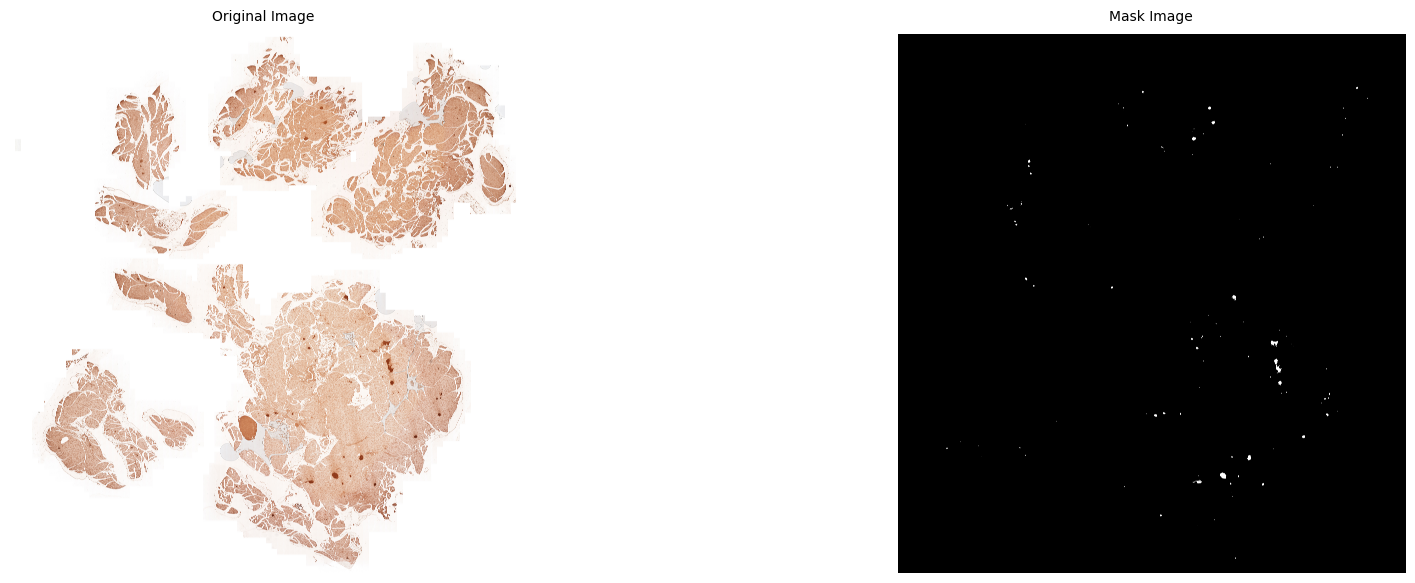

10.tif


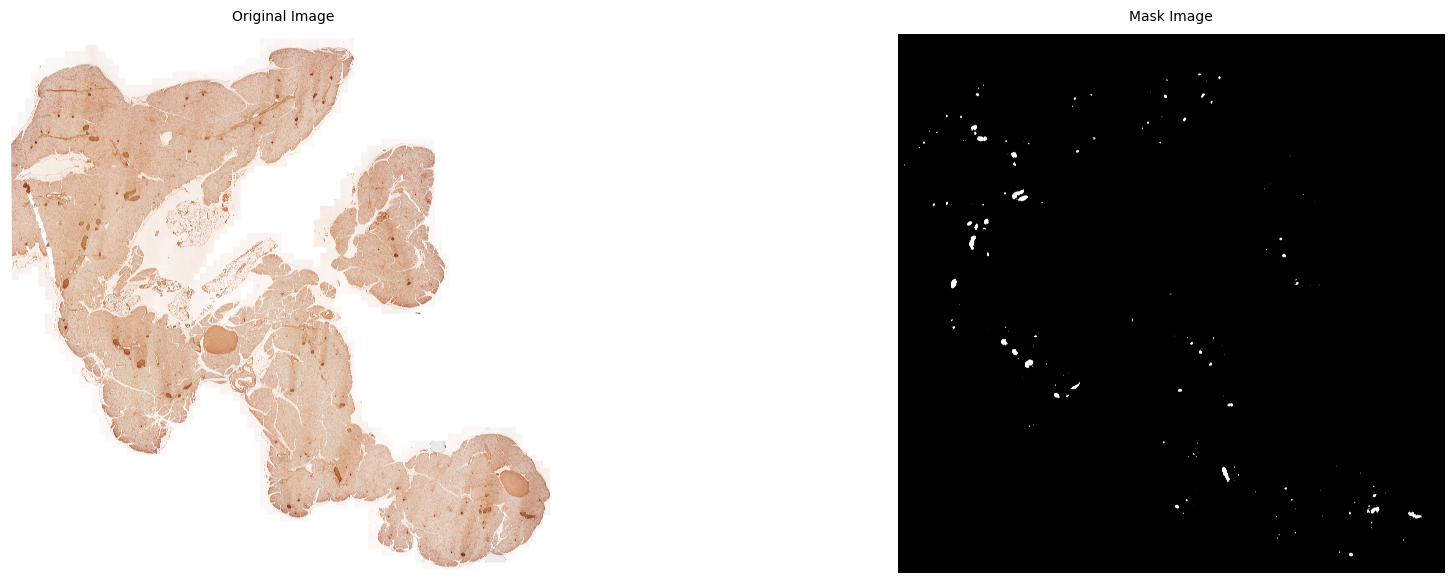

MemoryError: Unable to allocate 2.65 GiB for an array with shape (43520, 21760, 3) and data type bool

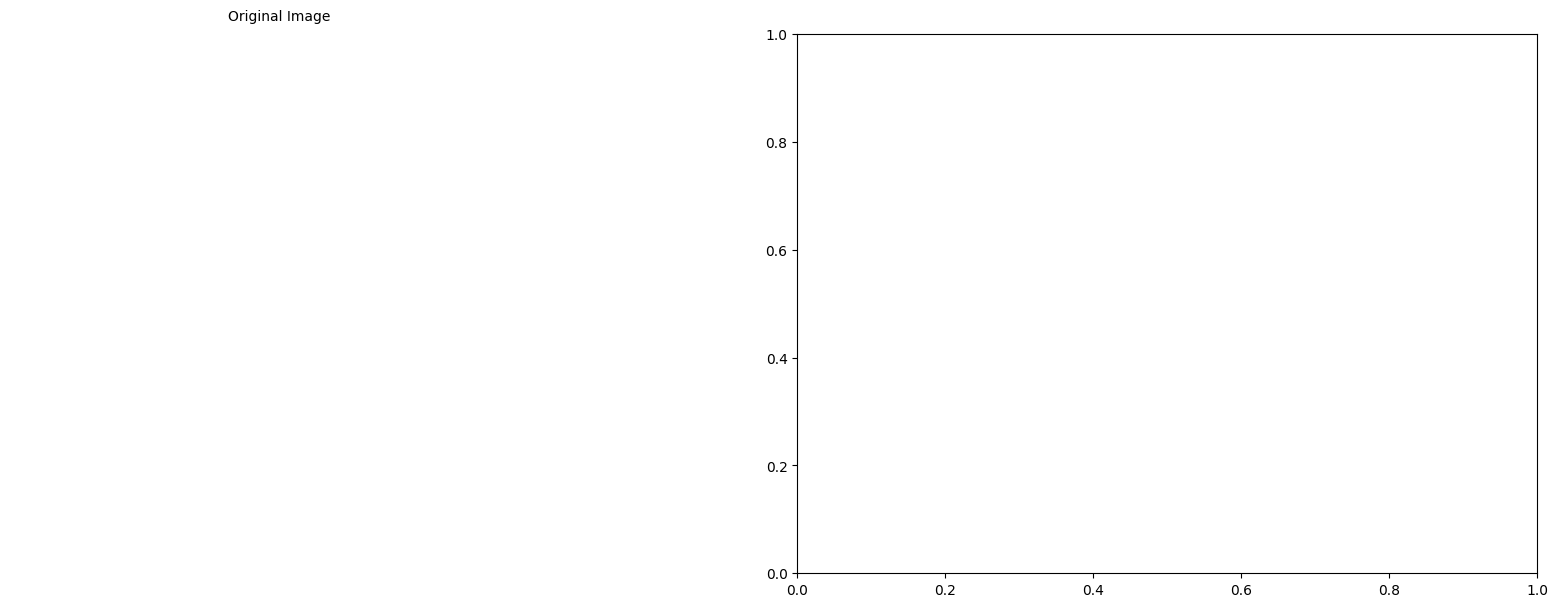

In [13]:
for n in range(len(mask_file)):
    mask_image = cv2.imread(os.path.join(mask_path, mask_file[n]))[:,:,0]

    image = cv2.imread(os.path.join(image_path, image_file[n]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 2, figsize=(21, 7), facecolor='white')

    axes[0].set_title('Original Image', fontsize = 10, pad = 10)
    axes[0].axis('off')
    axes[0].imshow(image)

    axes[1].set_title('Mask Image', fontsize = 10, pad = 10)
    axes[1].axis('off')
    axes[1].imshow(mask_image, cmap='gray')
    
    print(mask_file[n])
    plt.show()

### tiles setting

In [16]:
rebuild_dir(sample_crop)
rebuild_dir(sample_label)

In [17]:
def cropping_image(df, save_path):
    print("전체 사진 수: ", len(df))
    size = 512
    for idx in (df.index):
        base_names = df.loc[idx,'base_names']    
        img_path = df.loc[idx,'file_dir']

        img_rgb=cv2.imread(img_path, cv2.IMREAD_COLOR)  # 원본이미지
        max_height,max_width = img_rgb.shape[0],img_rgb.shape[1]
        
        num=0
        
        label_dir = df.loc[idx,'autolabeling_dir']
        result_dir = df.loc[idx,'img_dir']

        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        if not os.path.exists(result_dir):
            os.makedirs(result_dir)        

        for height in tqdm(range(0, img_rgb.shape[0], size)):
            for width in range(0, img_rgb.shape[1], size):

                img_rgb_crop = img_rgb[height:height+size, width:width+size, :]  # 30*30 절삭(높이, 너비)
                if height+size > max_height or width+size > max_width:
                    pass
                else:
                    name = str(base_names)+'_TIFF_Cropped_'+'%05d.png' % num
                    tile_dir = os.path.join(save_path, name)
                    cv2.imwrite(tile_dir,img_rgb_crop)
                    num += 1
                    
        print(f"파일명: {df.loc[idx,'file_name']}\nSaved cropped image: {num}")
        
    
cropping_image(df, sample_crop)


전체 사진 수:  1


100%|██████████| 43/43 [00:12<00:00,  3.37it/s]


파일명: 1.tif
Saved cropped image: 1680


## Model

### dataset

In [18]:
class InferenceDataset(BaseDataset):
    CLASSES = ['x' for x in range(255)]
    CLASSES.append('cell')

    def __init__(
        self,
        images_dir,
        images_files,
        classes=None,
        preprocessing=None,
    ):
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in (images_files)]  # image_path
        self.preprocessing = preprocessing
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.tile_size = 512

        # 전체 이미지에서 모든 타일 정보를 미리 생성
        self.tiles_info = []
        for img_idx, image_path in enumerate(self.images_fps):
            image = cv2.imread(image_path)
            height, width, _ = image.shape
            
            for h in range(0, height, self.tile_size):
                for w in range(0, width, self.tile_size):
                    self.tiles_info.append({
                        'img_idx': img_idx, # 원본 이미지 인덱스
                        'h_start': h,
                        'w_start': w,
                    })

    def __getitem__(self, i):
        # i번째 타일 정보 가져오기
        tile_info = self.tiles_info[i]
        img_idx = tile_info['img_idx']
        h_start = tile_info['h_start']
        w_start = tile_info['w_start']
        
        # 원본 이미지 로드
        image_path = self.images_fps[img_idx]
        image = cv2.imread(image_path)
        # 흑백일 때(2D array) BGR로 바꿔 주기
        if image.ndim == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        else:
            # 컬러 파일이라면 기본 BGR 로드 → RGB 로 변환
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        
        # 타일 크롭
        tile = image[h_start:h_start+self.tile_size, w_start:w_start+self.tile_size]
        
        # 전처리 적용
        if self.preprocessing:
            sample = self.preprocessing(image=tile)
            tile = sample['image']

        # 원본 이미지의 이름과 크기 정보 반환
        original_image_name = os.path.splitext(os.path.basename(image_path))[0]    
        original_height, original_width, _ = image.shape
        
        return tile, h_start, w_start, original_height, original_width, original_image_name

    def __len__(self):
        return len(self.tiles_info)

In [19]:
# def get_validation_augmentation():
#     """Add paddings to make image shape divisible by 32"""
#     test_transform = [
#         albu.PadIfNeeded(512, 512, always_apply=True)
#     ]
#     return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    if x.ndim == 2:  # 채널이 없는 경우    
        x = np.expand_dims(x, axis=-1)  # (H, W) → (H, W, 1)
    if x.shape[2] == 1:  # 1채널일 경우 → 3채널로 반복
        x = np.repeat(x, 3, axis=2)
    x = x.transpose(2, 0, 1).astype('float32')  # (C, H, W)
    return torch.from_numpy(x)

def get_preprocessing(preprocessing_fn):

    _transform = [
        albu.PadIfNeeded(512, 512, always_apply=True, border_mode=cv2.BORDER_CONSTANT, value=0),
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)

In [20]:
ENCODER = 'efficientnet-b2'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['cell']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 8
# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
print(DEVICE)

cpu


In [21]:
# Create test dataset
test_dataset = InferenceDataset(
    images_dir=image_path,
    images_files=image_file,
    classes=CLASSES,
    # augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)

In [22]:
def inference_collate_fn(batch):
    """
    batch: [(tile, h, w, H, W, name),  … ]  형태의 리스트
    -> ([tiles…], [h_starts…], [w_starts…], [heights…], [widths…], [names…])
    """
    tiles, h_starts, w_starts, heights, widths, names = zip(*batch)
    tiles_batch = torch.stack(tiles)
    # tiles: tuple of tensors, h_starts 등은 tuple of int, names는 tuple of str
    return (tiles_batch), list(h_starts), list(w_starts), list(heights), list(widths), list(names)


In [23]:
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, # 한 번에 하나의 원본 이미지(의 타일들)를 처리
    shuffle=False, 
    num_workers=0,  # num_workers/는 시스템의 CPU 코어 수를 활용할 수 있지만, 여기서는 0으로 설정하여 단일 프로세스에서 실행
    # num_workers=os.cpu_count(), # 시스템의 CPU 코어 수 활용
    collate_fn=inference_collate_fn
)

### 모델 로그

In [28]:
best_model = torch.load(
    os.path.join(ckpt_path, 'Full_Image_model2.pth'), map_location=DEVICE, 
    mmap= False # 메모리 맵 사용 비활성화
)

C:\Users\yy\AppData\Local\Temp\ipykernel_7980\1718234081.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(


In [54]:
import torch, os
ckpt_file = os.path.join(ckpt_path, 'Full_Image_model2.pth')
ckpt = torch.load(ckpt_file, map_location=DEVICE)

print("ckpt size:", os.path.getsize(ckpt_file))
print("ckpt type:", type(ckpt))
if isinstance(ckpt, dict):
    print("keys:", ckpt.keys())


ckpt size: 42199701
ckpt type: <class 'segmentation_models_pytorch.decoders.unetplusplus.model.UnetPlusPlus'>


C:\Users\yy\AppData\Local\Temp\ipykernel_16076\2727069070.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_file, map_location=DEVICE)


In [29]:
def has_less_white_pixels(image_path, threshold = 1):
    """
    이미지 내에 지정된 threshold 값 미만의 흰색 픽셀이 있는지 확인합니다.
    :param image_path: 이미지 파일의 경로
    :param threshold: 흰색 픽셀의 최대 수
    :return: 지정된 threshold 값을 미만의 흰색 픽셀이 있으면 True, 그렇지 않으면 False
    """
    white_pixel_count = 0
    try:
        with Image.open(image_path) as img:
            # 이미지 모드 확인: 'L' 모드는 흑백, 'RGB'는 컬러
            if img.mode != 'L':
                # 흑백이 아니면 흑백으로 변환하여 픽셀 값 비교를 용이하게 합니다.
                img = img.convert('L')
            
            pixels = img.getdata()
            
            # 각 픽셀 값이 255(흰색)인지 직접 확인
            for pixel in pixels:
                if pixel == 255:
                    white_pixel_count += 1
                if white_pixel_count >= threshold:
                    return False
        return True
    except Exception as e:
        print(f"이미지 처리 중 오류 발생: {e}")
        return False # 오류 발생 시 False 반환

In [30]:
def draw_contours_on_image(image, mask, color):
    """Mask의 테두리를 주어진 색상으로 이미지에 그립니다."""
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    image_with_contours = image.copy()
    cv2.drawContours(image_with_contours, contours, -1, color, 5*2)
    return image_with_contours

def count_pixels_in_mask(mask):
    """마스크 안의 픽셀 수를 반환합니다."""
    return np.sum(mask)

### model inference

In [31]:
@torch.no_grad() # 추론 시에는 그래디언트 계산을 비활성화하여 메모리 사용량을 줄이고 속도를 높입니다.
def inference_on_folder(model, dataloader, device,inference_dir):
    model.eval().to(device)
    progress_bar = tqdm(dataloader, desc="Inference Progress")
    
    full_masks = {}
    num = 0
    
    for i, data in enumerate(progress_bar):
        tiles_batch, h_starts, w_starts, heights, widths, image_names = data
        #print(f"\n[{i+1}/{len(dataloader)}] 배치 추론 중...")        
        tiles_batch = (tiles_batch).to(device)  
        
        # 모델 예측
        prediction = model(tiles_batch) # 출력: (batch_size, num_classes, H, W)
        predictions = prediction.cpu().numpy() 
        
        for j in range(len(image_names)):
            img_name = image_names[j]
            h_start = h_starts[j]
            w_start = w_starts[j]
            height = heights[j]
            width = widths[j]
            predicted_mask_tile = predictions[j]
            # 활성화 함수 적용 후 CPU로 이동하고 NumPy 배열로 변환
            # sigmoid 활성화 함수를 사용하면 [0, 1] 범위의 확률 맵이 출력됩니다.
            # 'cell' 클래스 하나만 예측하므로 prediction.squeeze()를 사용합니다.
            # threshold를 적용하여 이진 마스크로 변환 (0.5 이상이면 1, 아니면 0)
            
            # 단일 클래스 이진 세그멘테이션의 경우 (1, H, W) -> (H, W)
            if len(CLASSES) == 1:
                predicted_mask_tile = predicted_mask_tile.squeeze(0) # (H, W)
                predicted_mask_tile = (predicted_mask_tile > 0.5).astype(np.uint8) * 255 # 이진 마스크로 변환 (0 또는 255)
            else:
                # 다중 클래스 세그멘테이션의 경우 argmax 사용
                predicted_mask_tile = np.argmax(predicted_mask_tile, axis=0).astype(np.uint8) # (H, W)
                # 클래스 ID를 실제 픽셀 값으로 매핑해야 할 수 있습니다. (예: 0, 1, 2... 에 따라 다른 색상)
                # 여기서는 예시로 255로 스케일링하여 저장합니다.
                predicted_mask_tile = predicted_mask_tile * (255 // (len(CLASSES) -1)) if len(CLASSES) > 1 else predicted_mask_tile * 255
            tile_path = os.path.join(inference_dir,f"{img_name}_crop", f"{num:05d}.png")
            cv2.imwrite(tile_path, predicted_mask_tile)     
            
            if has_less_white_pixels(tile_path):
                os.remove(tile_path)
                continue
            num += 1

            # --- 전체 마스크 재구성 로직 ---
            # 현재 이미지에 대한 전체 마스크가 딕셔너리에 없으면 초기화
            if img_name not in full_masks:
                full_masks[img_name] = np.zeros((height, width), dtype=np.uint8)
            
            h_end = min(h_start + 512, height)
            w_end = min(w_start + 512, width)
            
            # 재구성할 마스크의 실제 높이와 너비
            actual_reconstruct_height = h_end - h_start
            actual_reconstruct_width = w_end - w_start
            
            # 예측된 타일 마스크에서 원본 영역에 해당하는 부분만 추출
            reconstructed_tile = predicted_mask_tile[:actual_reconstruct_height, :actual_reconstruct_width]
            
            # 전체 마스크에 재구성
            full_masks[img_name][h_start:h_end, w_start:w_end] = reconstructed_tile
        # 현재 배치의 추론 진행 상황 출력
        #print(f"[{i+1}/{len(dataloader)}] 배치 추론 완료.")

    # 모든 배치가 처리된 후, 최종 마스크들을 파일로 저장
    print("\n모든 이미지 타일 추론이 완료되었습니다. 최종 결과를 저장합니다. 💾") 
    return full_masks
    
# 추론 실행
full_masks = inference_on_folder(best_model, test_dataloader, DEVICE, sample_label)


Inference Progress:   2%|▏         | 4/215 [02:14<1:58:33, 33.71s/it]


KeyboardInterrupt: 

In [ ]:
idx = 0
for img_name,full_mask in (full_masks.items()):
    image = cv2.imread(os.path.join(df.loc[idx, 'file_dir']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # output_dir = os.path.join(df.loc[idx, 'img_dir'], f"{img_name}_contours.png")
    result_dir = os.path.join(sample_segmentation, f"{img_name}_segmentation.png")
    
    # cv2.imwrite(output_dir, image_with_prediction_contours)
    cv2.imwrite(result_dir, full_mask)
    print(f"'{img_name}'의 예측 마스크를 '{result_dir}'에 저장했습니다. ✅")

'1'의 예측 마스크를 'c:\Users\yy\Desktop\school\CAPSTONE\submit\hbnu-swuniv-capstone-project-come-capstone25-CAPSTONE-InnoMedics\003 Code\model_train\result\prediction\1_result\1_contours.png'에 저장했습니다. ✅
'10'의 예측 마스크를 'c:\Users\yy\Desktop\school\CAPSTONE\submit\hbnu-swuniv-capstone-project-come-capstone25-CAPSTONE-InnoMedics\003 Code\model_train\result\prediction\10_result\10_contours.png'에 저장했습니다. ✅
'11'의 예측 마스크를 'c:\Users\yy\Desktop\school\CAPSTONE\submit\hbnu-swuniv-capstone-project-come-capstone25-CAPSTONE-InnoMedics\003 Code\model_train\result\prediction\11_result\11_contours.png'에 저장했습니다. ✅
'12'의 예측 마스크를 'c:\Users\yy\Desktop\school\CAPSTONE\submit\hbnu-swuniv-capstone-project-come-capstone25-CAPSTONE-InnoMedics\003 Code\model_train\result\prediction\12_result\12_contours.png'에 저장했습니다. ✅
'13'의 예측 마스크를 'c:\Users\yy\Desktop\school\CAPSTONE\submit\hbnu-swuniv-capstone-project-come-capstone25-CAPSTONE-InnoMedics\003 Code\model_train\result\prediction\13_result\13_contours.png'에 저장했습니다. ✅


## data_analyze

### mask

In [ ]:
for i in df.index:
    name = df.loc[i,'base_names']
    img_path = df.loc[i,'img_dir']

    img=cv2.imread(os.path.join(img_path,f"{name}_original"), cv2.IMREAD_COLOR)  # 원본이미지
    img_blurrd = cv2.imread(os.path.join(img_path,f"{name}_blurrd"), cv2.IMREAD_COLOR)

    prediction_img_path = os.path.join(df.loc[i,'img_dir'], f"{name}_contours.png")
    prediction_img = cv2.imread(prediction_img_path, cv2.IMREAD_COLOR)
    histogram = cv2.imread(os.path.join(img_path,f"{name}_histogram"), cv2.IMREAD_COLOR)

    mask_path = os.path.join(sample_segmentation, f"{name}_mask.png")
    full_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

1.tif
원본 마스크 픽셀 수: 118612230, 예측 마스크 픽셀 수: 770272890
IOU: 0.1508


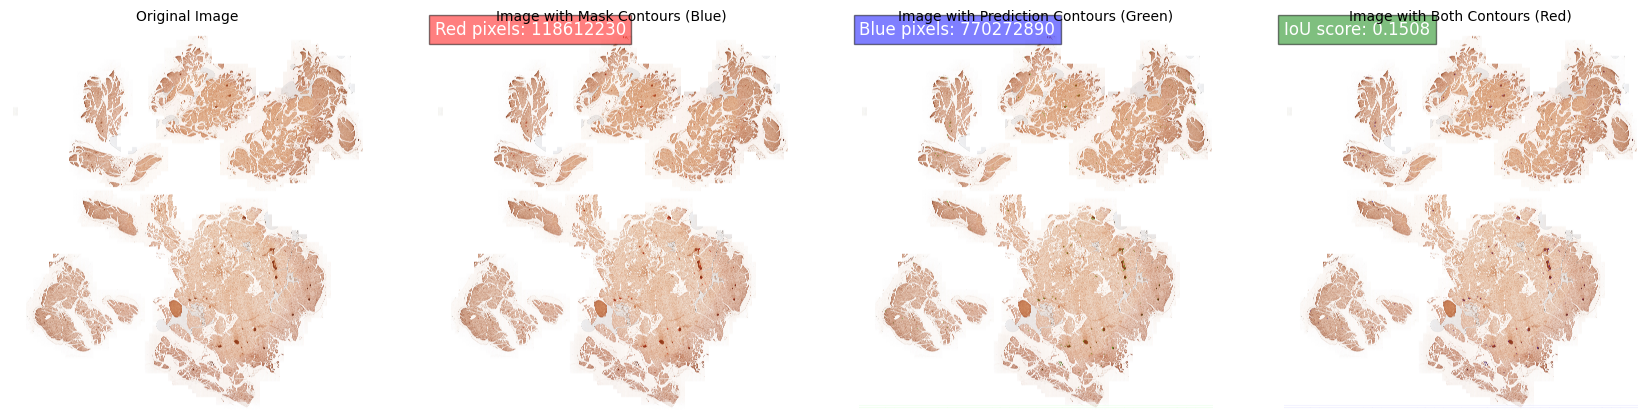

12.tif
원본 마스크 픽셀 수: 314964525, 예측 마스크 픽셀 수: 324104235
IOU: 0.9325


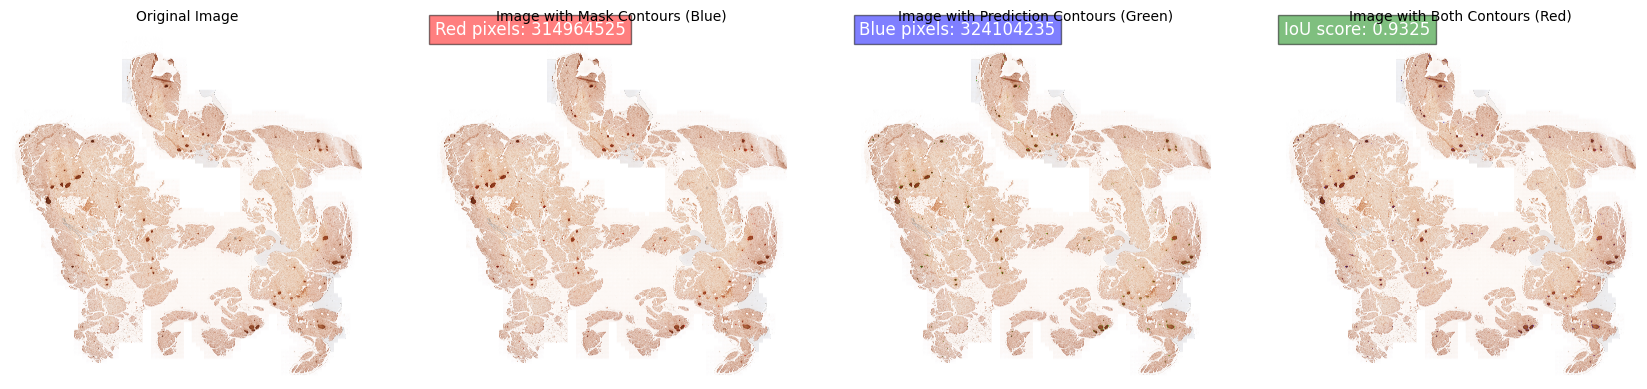

13.tif
원본 마스크 픽셀 수: 222778710, 예측 마스크 픽셀 수: 234811395
IOU: 0.9124


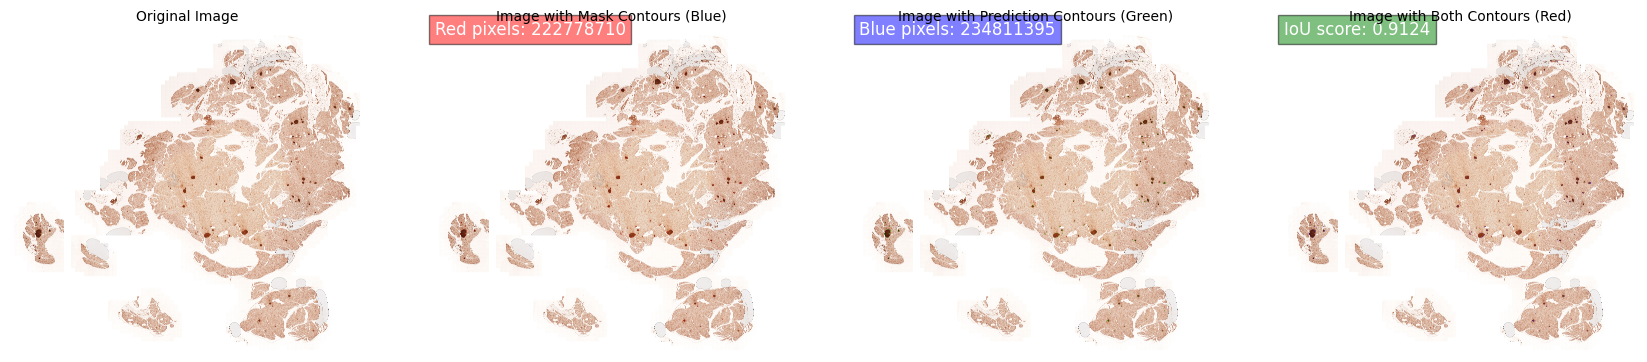

In [ ]:
for i in df.index:
    print(df.loc[i,'file_name'])
    image = cv2.imread(df.loc[i,'file_dir'], cv2.IMREAD_COLOR)  # 원본이미지
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR로 읽으므로 RGB로 변환

    mask_image = cv2.imread(os.path.join(mask_path, df.loc[i,'file_name']), cv2.IMREAD_GRAYSCALE)  # 훈련 마스크
    prediction_image = cv2.imread(os.path.join(sample_prediction, f"{df.loc[i,'base_names']}_segmentation.png"), cv2.IMREAD_GRAYSCALE)  # 예측 마스크

    if mask_image is None or prediction_image is None:
        print(f"마스크 또는 예측 이미지를 불러올 수 없습니다: {df.loc[i,'file_name']}")
        continue

    # 마스크와 예측 이미지의 픽셀 수 계산
    mask_pixel_count = count_pixels_in_mask(mask_image)
    prediction_pixel_count = count_pixels_in_mask(prediction_image)
    print(f"원본 마스크 픽셀 수: {mask_pixel_count}, 예측 마스크 픽셀 수: {prediction_pixel_count}")
    
    # 마스크와 예측 이미지의 테두리를 원본 이미지에 그리기
    image_with_mask_contours = draw_contours_on_image(image, mask_image.astype(np.uint8), (255, 0, 0))  # 파란색 mask 테두리
    image_with_prediction_contours = draw_contours_on_image(image, prediction_image.astype(np.uint8), (0, 255, 0))  # 초록색 prediction 테두리
    image_with_both_contours = draw_contours_on_image(image_with_mask_contours, prediction_image.astype(np.uint8), (0, 0, 255))  # 빨간색 테두리
    # 결과 이미지 출력

    # IOU 계산
    intersection = cv2.bitwise_and(mask_image, prediction_image)
    union = cv2.bitwise_or(mask_image, prediction_image)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0
    print(f"IOU: {iou:.4f}")

    fig, axes = plt.subplots(1, 4, figsize=(21, 7), facecolor='white')

    axes[0].set_title('Original Image', fontsize = 10, pad = 10)
    axes[0].axis('off')
    axes[0].imshow(image)
    
    axes[1].set_title('Image with Mask Contours (Blue)', fontsize = 10, pad = 10)
    axes[1].axis('off')
    axes[1].imshow(image_with_mask_contours)
    
    axes[2].set_title('Image with Prediction Contours (Green)', fontsize = 10, pad = 10)
    axes[2].axis('off')
    axes[2].imshow(image_with_prediction_contours)
    
    axes[3].set_title('Image with Both Contours (Red)', fontsize = 10, pad = 10)
    axes[3].axis('off')
    axes[3].imshow(image_with_both_contours)
    
    # 각 subplot에 텍스트 추가
    axes[1].text(10, 10, f'Red pixels: {mask_pixel_count}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    axes[2].text(10, 10, f'Blue pixels: {prediction_pixel_count}', color='white', fontsize=12, bbox=dict(facecolor='blue', alpha=0.5))
    axes[3].text(10, 10, f'IoU score: {iou:.4f}', color='white', fontsize=12, bbox=dict(facecolor='green', alpha=0.5))

    base_name = df.loc[i,'base_names']
    
    # plt.savefig(os.path.join(sample_imgs, 'sample_compare_%05d.png' % base_name))
    plt.show()


### histogram

## 시각화

In [107]:
for idx in os.listdir(sample_prediction):
    print(idx)
    base_name = '_'.join(idx.split('_')[:-1])
    print(base_name)
    
    original_image_path = [x for x in df['file_dir'] if base_name in x][0]
    print(original_image_path)
    
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR로 읽으므로 RGB로 변환
    
    prediction_mask_path = os.path.join(sample_prediction, idx)
    prediction_mask = cv2.imread(prediction_mask_path, cv2.IMREAD_GRAYSCALE)
    
    # 예측 마스크의 픽셀 수 계산
    pixel_count = count_pixels_in_mask(prediction_mask)
    print(f"Mask pixel count: {pixel_count}")
    
    if pixel_count < 1:
        print(f"Mask for {base_name} has less than 1 pixel, skipping.")
        continue
    
    # 원본 이미지에 예측 마스크의 테두리를 빨간색으로 그림
    image_with_contours = draw_contours_on_image(original_image, prediction_mask, color=(0, 255, 0))
    
    # 결과 이미지 저장
    compare_save_path = os.path.join(sample_imgs, f"{base_name}_compare.png")
    cv2.imwrite(compare_save_path, cv2.cvtColor(image_with_contours, cv2.COLOR_RGB2BGR))  # 저장 시 다시 BGR로 변환
    print(f"Saved comparison image to {compare_save_path}\n")

1_mask.png
1
c:\Users\yy\Desktop\school\CAPSTONE\main\model\Full_Image\original_data\TG\TIFF\1.tif
Mask pixel count: 466695645
Saved comparison image to c:\Users\yy\Desktop\school\CAPSTONE\main\result\imgs\1_compare.png



In [ ]:
def blurrd_img(tiff_files):
    ## 원본 이미지
    original_img = cv2.imread(tiff_files, cv2.IMREAD_COLOR)

    img = cv2.imread(tiff_files, cv2.IMREAD_COLOR)

    ## 블러 처리
    blur = cv2.medianBlur(img, 9)

    hsv_img = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)

    ## hsv 채널분리
    h, s, v = cv2.split(hsv_img)

    _, thr_s = cv2.threshold(s, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    __cached__, thr_v = cv2.threshold(v, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    thr_v -= 255

    # Contours 찾기
    contours_s, _ = cv2.findContours(thr_s, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_v, _ = cv2.findContours(thr_v, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    contour_img_s = thr_s.copy()
    cn_filled_s = cv2.drawContours(contour_img_s, contours_s, -1, (255,255,255), -1)

    contour_img_v = thr_v.copy()
    cn_filled_v = cv2.drawContours(contour_img_v, contours_v, -1, (255,255,255), -1)

    ## hsv 채널 중 s,v 채널 영역 합침
    mask_area = cv2.bitwise_and(cn_filled_s, cn_filled_v)

    # Contours 찾기
    contours, _ = cv2.findContours(mask_area, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Contours를 그릴 이미지 생성
    contour_img = mask_area.copy()

    # Contours 그리기
    cn_filled = cv2.drawContours(contour_img, contours, -1, (255,255,255), -1)

    result_img = img.copy()
    result_img[np.logical_not(cn_filled)] = [255, 255, 255]  # 흰색으로 채우기

    return result_img

plt.imshow(blurrd_img(tiff_files[0]))

In [ ]:
# Predict on the tiled test images
full_masks = predict_tiled_images(test_dataset, model, device=DEVICE)



In [ ]:
# Visualize the results (optional)
for idx, mask in enumerate(full_masks):
    plt.figure(figsize=(10, 10))
    plt.imshow(mask, cmap='gray')
    plt.title(f'Prediction {idx}')
    plt.show()